In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
root = 'https://saopaulo.publicbikesystem.net/ube/gbfs/v1/'
endpoints = requests.get(root).json()['data']['en']['feeds']

In [ ]:
main = endpoints[1]
main

{'name': 'station_information',
 'url': 'https://saopaulo-br.publicbikesystem.net/customer/ube/gbfs/v1/en/station_information'}

In [ ]:
raw_station_information = requests.get(main['url']).json()['data']['stations']
station_information = pd.DataFrame(raw_station_information)
station_information.head(3)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,planned_date
0,1,1 - Largo da Batata,REGULAR,-23.566831,-46.693741,0.0,"Av. Brigadeiro Faria Lima, esquina R. Teodoro ...",82,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],1,1000.0,NaN,NaN
1,3,3 - CPTM Pinheiros,VAULT,-23.566478,-46.701258,0.0,"R. Gilberto Sabino, 138/ ao lado do ponto de ô...",15,"[KEY, TRANSITCARD, PHONE]",[Pinheiros],3,1000.0,03164200,NaN
2,4,4 - Rua Diogo Moreira,REGULAR,-23.569145,-46.692003,0.0,"Av. Brigadeiro Faria Lima, na altura do número...",23,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],4,1000.0,03164200,NaN


In [ ]:
station_information['lng_lat'] = station_information[['lon', 'lat']].apply(tuple, axis=1)
station_information['geometry'] = station_information.lng_lat.apply(lambda p: Point(p))
station_information = gpd.GeoDataFrame(station_information)
station_information.head(3)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,planned_date,lng_lat,geometry
0,1,1 - Largo da Batata,REGULAR,-23.566831,-46.693741,0.0,"Av. Brigadeiro Faria Lima, esquina R. Teodoro ...",82,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],1,1000.0,NaN,NaN,"(-46.6937412022694, -23.5668309564147)",POINT (-46.69374 -23.56683)
1,3,3 - CPTM Pinheiros,VAULT,-23.566478,-46.701258,0.0,"R. Gilberto Sabino, 138/ ao lado do ponto de ô...",15,"[KEY, TRANSITCARD, PHONE]",[Pinheiros],3,1000.0,03164200,NaN,"(-46.7012582819428, -23.5664776214954)",POINT (-46.70126 -23.56648)
2,4,4 - Rua Diogo Moreira,REGULAR,-23.569145,-46.692003,0.0,"Av. Brigadeiro Faria Lima, na altura do número...",23,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],4,1000.0,03164200,NaN,"(-46.6920025786078, -23.5691446194095)",POINT (-46.69200 -23.56914)


In [ ]:
import geobr
import matplotlib.pyplot as plt

In [ ]:
# Municipality of Sao Paulo
muni = geobr.read_municipality(code_muni=3550308, year=2020)
muni.head()

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
562,3550308.0,São Paulo,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((-46.54624 -23.35791, -46.54214..."


In [ ]:
type(muni)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:title={'center':'Municipality of São Paulo, 2020'}>

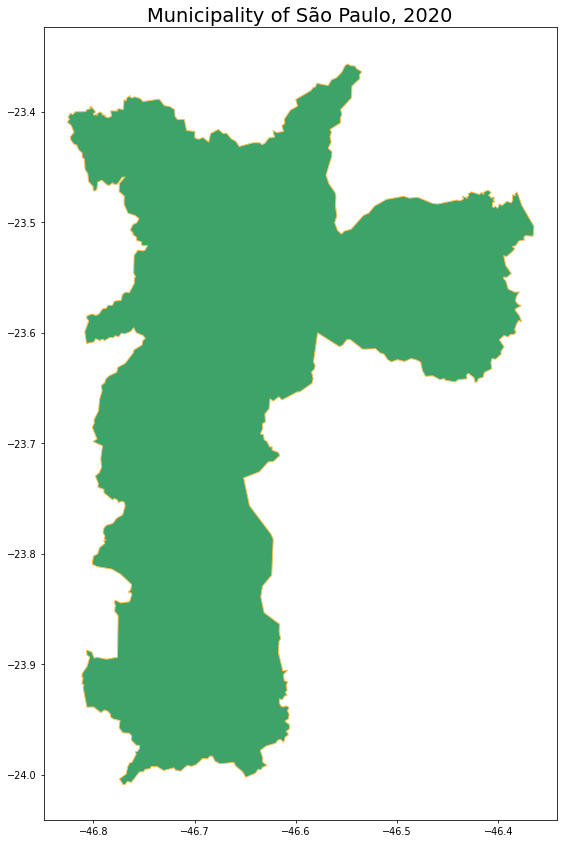

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15), dpi=70)
ax.set_title("Municipality of São Paulo, 2020", fontsize=20)
muni.plot(facecolor="#3ea368", edgecolor="#FEBF57", ax=ax)

In [ ]:
# Creating a MultiPolygon object
muni_multipoly = muni.iloc[0].geometry
type(muni_multipoly)

shapely.geometry.multipolygon.MultiPolygon

In [ ]:
print(muni_multipoly.centroid)

POINT (-46.64815177560724 -23.65004381777975)


In [ ]:
# Selects the coordinates of each bike rack
coords = []
for _, i in station_information.iterrows():
  lat = i['geometry'].x
  lon = i['geometry'].y
  coords.append([lat,lon])
type(coords)

list

In [ ]:
import numpy as np

In [ ]:
# Transforming coordinates into a numpy array of lists
arcoords = np.array(list(map(list, coords)))
type(arcoords)

numpy.ndarray

In [ ]:
from geovoronoi import voronoi_regions_from_coords
import folium as f

In [ ]:
# Voronoi function:
region_polys, region_pts = voronoi_regions_from_coords(arcoords, muni_multipoly)

In [ ]:
def newMap():
    return f.Map(location=[-23.549279718284097, -46.63297420696871], zoom_start=12, tiles="cartodbpositron")

In [ ]:
m = newMap()

for count, r in enumerate(region_polys.values()):
  geo_j = f.GeoJson(data=r, style_function=lambda x: {'fillColor': 'lightblue', 'color' : 'gray'})
  geo_j.add_to(m)
m

In [ ]:
for i in coords:
  f.Circle(radius=15, location=[i[1], i[0]], color = 'blue', fill=True).add_to(m)
m

In [ ]:
m.save('VoronoiMap.html')

In [159]:
for count, r in enumerate(region_polys.values()):
  print(r.area)

0.0024487290823582268
2.9200717287934644e-05
0.0011014149053058054
0.006063314931347726
8.4055640653911e-05
0.00032295586355422014
0.00266631427529161
0.005087884514324026
0.0017667114575022336
1.9119534947292387e-05
0.0004927203594298614
3.719086908334273e-05
0.0002687676215900456
6.331345247425286e-05
5.1814982319483774e-05
0.00012966462361691279
0.01870888081905899
4.455740896297159e-05
4.711352532371474e-05
0.00235549517526607
3.873395025832799e-05
1.4128171527454283e-05
0.002785932877410257
8.348079794465177e-05
4.169602070623672e-05
1.86433396416294e-05
1.518149564689842e-05
3.3068120769798603e-05
1.6318277771387104e-05
1.7085897106509884e-05
1.5102923460053965e-05
9.75073125327584e-05
4.293321877900803e-05
0.0002853396679347245
2.366060255682293e-05
3.32252123033692e-05
0.00032363470717672056
3.4449659486408864e-05
0.000102611261144678
0.00011881275889618128
0.0035064090169649046
6.628598649566506e-05
0.0054073849691778034
1.8401728444631437e-05
3.215812228191879e-05
4.796692441

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
type(vor)

scipy.spatial.qhull.Voronoi

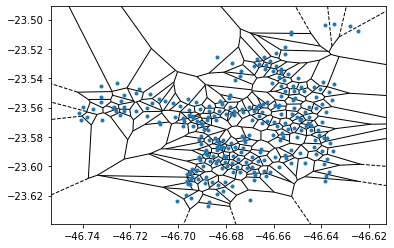

In [ ]:
# Static map
fig = voronoi_plot_2d(vor, show_vertices=False)
plt.show()